In [1]:
from typing import List

import numpy as np
import csv
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d

In [2]:
alphas = [0.25, 0.5, 0.75, 1.0]
# seeds = [12, 42, 69, 10420]
# seeds = [128, 4242, 1234, 48]
seeds = [12, 42, 69, 10420, 128, 4242, 1234, 48]
# postfix = '_arch'
postfix = ''

In [3]:
def interpolate(x, y, at):
    return interp1d(x, y, kind="linear", fill_value=(np.min(y), np.max(y)), bounds_error=False)(at)

def plot(all_evals: List, label: str, smooth_factor=2, color="b", max_samples=None, eval_rate=None):
    intervals = np.arange(0, max_samples, eval_rate)
    all_evals = np.stack([interpolate(np.array(evals)[:,0],np.array(evals)[:,1],intervals) for evals in all_evals])
    mean_reward = all_evals.mean(axis=0)
    sem_reward = sem(all_evals, axis=0)
    ci_95 = 1.96 * sem_reward

    mean_reward_smooth = gaussian_filter1d(mean_reward, smooth_factor)
    ci_95_smooth = gaussian_filter1d(ci_95, smooth_factor)

    plt.plot(intervals, mean_reward_smooth, label=label, color=color)
    plt.fill_between(intervals, mean_reward_smooth - ci_95_smooth, mean_reward_smooth + ci_95_smooth, color=color, alpha=0.2)

def load_evals(path):
    with open(path, newline='') as file:
        rd = csv.reader(file)
        return np.array(list(rd), dtype='float')

[['/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.25_seed_12_arch', '/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.25_seed_42_arch'], ['/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.5_seed_12_arch', '/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.5_seed_42_arch']]


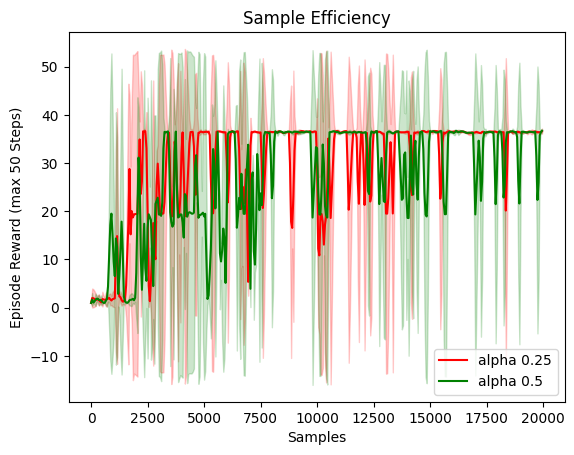

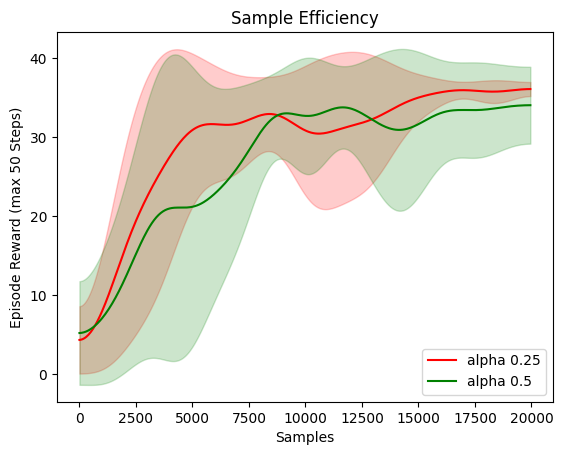

In [8]:
path = Path.cwd()
path = path / "stackelberg_mbrl" / "experiments" / "poster_mal_agent_reward" / "sample_efficiency" / "alpha"
colors = ['r', 'g', 'b', 'm']
paths = [[f"{path}_{alpha}_seed_{seed}{postfix}" for seed in seeds] for alpha in alphas]
print(paths)
evals = [[load_evals(p) for p in a] for a in paths]
max_samples = max([max([np.max(x[:, 0]) for x in a]) for a in evals])

for smooth_factor in [0.1, 20]:
    plt.figure()
    # smooth_factor = 20.0
    for e, a, c in zip(evals, alphas, colors):
        plot(e, f"alpha {a}", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c)
        
    plt.title("Sample Efficiency")
    plt.ylabel("Episode Reward (max 50 Steps)")
    plt.xlabel("Samples")
    plt.legend()

# This part is just for creating data

In [7]:
%load_ext autoreload
%autoreload 2

from stackelberg_mbrl.experiments.experiment_config import ExperimentConfig, EnvConfig, PolicyConfig, WorldModelConfig, LoadPolicy, LeaderEnvConfig, SampleEfficiency
from stackelberg_mbrl.train_mal import train_contextualized_MAL
from itertools import product

for alpha, seed in product(alphas, seeds):
    config = ExperimentConfig(
        experiment_name="poster_mal_agent_reward",
        env_config=EnvConfig(
            env_true_id="simple_mdp_2",
            env_eval_id="simple_mdp_2",
            max_episode_steps=50
        ),
        policy_config=LoadPolicy(
            path="stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip",
        ),
        # policy_config=PolicyConfig(
        #     pretrain_iterations=1,
        #     samples_per_training_iteration=1_000_000,
        #     model_save_name="policy_simple_mdp_2",
        # ),
        leader_env_config=LeaderEnvConfig(
            env_reward_weight=alpha
        ),
        sample_efficiency=SampleEfficiency(
            sample_eval_rate=100,
            n_eval_episodes=30,
            max_samples=20_000,
            log_save_name=f"alpha_{alpha}_seed_{seed}{postfix}"
        ),
        world_model_config=WorldModelConfig(
            total_training_steps=250_000,
            # total_training_steps=1_000,
            # model_save_name="simple_mdp_2",
        ),
        seed=seed
    )

    train_contextualized_MAL(config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.25_seed_12_arch.
Model reward: (9.037637692410499, 0.36785053837381515)
Avg Policy Reward on learned model:   19.470 ± 10.191
Avg Policy Reward on real env:   36.130 ± 1.568
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.25_seed_42_arch.
Model reward: (8.812869895994663, 0.5104819518753326)
Avg Policy Reward on learned model:   3.110 ± 2.842
Avg Policy Reward on real env:   36.130 ± 1.348
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.5_seed_12_arch.
Model reward: (18.283726136386395, 0.36407251741257984)
Avg Policy Reward on learned model:   6.870 ± 8.327
Avg Policy Reward on real env:   35.890 ± 1.755
Loading policy model from file.


Output()

Training world model


saving 200 records into stackelberg_mbrl/experiments/poster_mal_agent_reward/sample_efficiency/alpha_0.5_seed_42_arch.
Model reward: (18.28892834931612, 0.4088583135250145)
Avg Policy Reward on learned model:   14.855 ± 10.992
Avg Policy Reward on real env:   36.530 ± 0.977
